# Automatic Audio-based Genre Classification

## I. Prepare Data

Both FMA and GTZAN split up the audio files into multiple folders. This section will loop through all the folders and extract the necessary features. The features are the 34 pyAudioAnalysis features collect in by small-frame of 1024 samples and step of 512 samples condensed into their means, standard deviations, skewnesses, and kurtosises, totaling 136 features. The genres for the FMA are retrieved from a metadata file called tracks.csv. The genres for GTZAN are simply the folder names the audio files are in. FMA had 16 genres originally, but many are unwanted and 6 will be removed. Only the remaining 10 FMA genres are extracted for features. The features are combined in a Pandas DataFrame and indexed by their dataset given index.

In the end, 20,075 of the 25,000 FMA files and all 1,000 GTZAN files were extracted successfully. All the extracted features were saved to a data.csv file for both datasets.

In [ ]:
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import audioFeatureExtraction
import matplotlib as plt
import numpy as np
import pandas as pd
import scipy as sp
import glob
import numpy
import os
from pyAudioAnalysis.audioFeatureExtraction import stFeatureExtraction

In [ ]:
# Load FMA Track MetaData

tracks = pd.read_csv("datasets/genres/fma/tracks.csv", header = 1, dtype = {'track_id': str, 'genre_top': str})
tracks.set_index('track_id', inplace=True)
print("Tracks Loaded")

In [ ]:
# Extracts features from a FMA folder

def FMA_feature_extraction(folder, outfile, extension = ".mp3"
                           ,genres = ["Rock", "Electronic", "Hip-Hop", "Folk", "Pop", "Classical", "Old-Time / Historic", "Blues", "Jazz", "Country"]):
    
    # Locates MP3 files in the specified folder
    print("Extracting from folder: " + folder)
    files = []
    files.extend(glob.glob(folder + "\\*" + extension))
    print("\t" + str(len(files)) + " files found")
    
    ids = [] # FMA given id for each track
    y = [] # FMA given genre for each track
    X = [] # statistics of pyAudioAnalysis generated short term features
    
    # Loops through each file
    for f in files:
        name = f[len(folder) + 1 :]
        name = name[: len(name) - len(extension)]
        i = str(int(name))
        track_genre = tracks.loc[i]["genre_top"]
        if track_genre in genres: # Check if genre of the track is one the reduced genres
            
            [fs, x] = audioBasicIO.readAudioFile(f)
            if isinstance(x, int):
                print(f + " Failed!")
                continue
                
            ids.append(i)
            y.append(track_genre)

            win = 1024
            step = win / 2
            x = audioBasicIO.stereo2mono(x)
            [st_features, _] = stFeatureExtraction(x, fs, win, step) # Extracts short term features
            
            means = np.mean(st_features, axis = 1)
            stds = np.std(st_features, axis = 1)
            skew = sp.stats.skew(st_features, axis = 1, bias = False)
            kurtosis = sp.stats.kurtosis(st_features, axis = 1, bias = False)
            
            features = np.concatenate([means, stds, skew, kurtosis])
            X.append(features)
            
    print("\tSuccessfully extracted from " + str(len(ids)) + " files")
    
    # Create DataFrame
    df_y = pd.DataFrame(index = ids, data = y)
    df_X = pd.DataFrame(index = ids, data = X)
    
    df = pd.concat([df_y, df_X], axis = 1)

    print("\tSaving DataFrame to " + outfile)
    df.to_csv(path_or_buf = outfile)
    
    print("Finished folder " + folder + "\n")
    return df

In [ ]:
# Extracts features from a GTZAN folder

def GTZAN_feature_extraction(genre, folder, outfile, extension = ".au"):
    
    # Locates audio files in the specified folder
    print("Extracting from folder: " + folder)
    files = []
    files.extend(glob.glob(folder + "\\*" + extension))
    print("\t" + str(len(files)) + " files found")
    
    ids = [] # GTZAN given id for each track
    y = [] # GTZAN given genre for each track
    X = [] # statistics of pyAudioAnalysis generated short term features
    
    # Loops through each file
    for f in files:
        name = f[len(folder) + 1 :]
        name = name[: len(name) - len(extension)]
        

        [fs, x] = audioBasicIO.readAudioFile(f)
        if isinstance(x, int):
            print(f + " Failed!")
            continue

        ids.append(name)
        y.append(genre)

        win = 1024
        step = win / 2
        x = audioBasicIO.stereo2mono(x)
        [st_features, _] = stFeatureExtraction(x, fs, win, step) # Extracts short term features

        means = np.mean(st_features, axis = 1)
        stds = np.std(st_features, axis = 1)
        skew = sp.stats.skew(st_features, axis = 1, bias = False)
        kurtosis = sp.stats.kurtosis(st_features, axis = 1, bias = False)

        features = np.concatenate([means, stds, skew, kurtosis])
        X.append(features)
            
    print("\tSuccessfully extracted from " + str(len(ids)) + " files")
    
    # Create DataFrame
    df_y = pd.DataFrame(index = ids, data = y)
    df_X = pd.DataFrame(index = ids, data = X)
    
    df = pd.concat([df_y, df_X], axis = 1)

    print("\tSaving DataFrame to " + outfile)
    df.to_csv(path_or_buf = outfile)
    
    print("Finished folder " + folder + "\n")
    return df

In [ ]:
# Sets up folders for feature extraction

gtzan_folders = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
def fma_folders(number = 155):
    folders = []
    for i in range(0, number + 1):
        name = str(i)
        while (len(name) < 3):
            name = "0" + name
        folders.append(name)
    return folders

data_temp = []
rendered = []
data_temp2 = []
rendered2 = []

In [ ]:
end = 155

# Extracts features from each folder in both datasets

for i, folder in enumerate(fma_folders()):
    if (i <= end and folder not in rendered):
        data_temp.append(FMA_feature_extraction("datasets\\genres\\fma\\" + folder, "datasets\\genres\\fma\\" + folder + "\\rendered.csv"))
        rendered.append(folder)
    else:
        print("Skipped " + folder)

for i, folder in enumerate(gtzan_folders):
    if folder not in rendered2:
        data_temp2.append(GTZAN_feature_extraction(folder, "datasets\\genres\\gtzan\\" + folder, "datasets\\genres\\gtzan\\" + folder + "\\rendered.csv"))
        rendered2.append(folder)
    else:
        print("Skipped " + folder)

In [ ]:
# Generates columns names

col_names = ["genre"]
stats = ["_mean", "_std", "_skew", "_kurtosis"]
features = ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std']
for stat in stats:
    for feature in features:
        col_names.append(feature + stat)
        
print(col_names)
print(len(col_names))

In [ ]:
# Gathers all the extracted features for FMA and combines them

fma_data = [];
for i, folder in enumerate(fma_folders()):
    fma_data.append(pd.read_csv("datasets\\genres\\fma\\" + folder + "\\rendered.csv", index_col = 0, header = 0, names = col_names))
                    
fma_data = pd.concat(fma_data)

In [103]:
# Gathers all the extracted features for GTZAN and combines them

gtzan_data = [];
for i, folder in enumerate(gtzan_folders):
    gtzan_data.append(pd.read_csv("datasets\\genres\\gtzan\\" + folder + "\\rendered.csv", index_col = 0, header = 0, names = col_names))
    
gtzan_data = pd.concat(gtzan_data)

In [106]:
# Check to make sure FMA and GTZAN were successfully loaded

print(fma_data) # Should be around 20,000 rows and 137 columns (20,075 X 137)
print(gtzan_data) # Should be exactly 1,000 rows and 137 columns (1,000 X 137)

             genre  zcr_mean  energy_mean  energy_entropy_mean  \
2          Hip-Hop  0.098553     0.028831             3.127077   
3          Hip-Hop  0.089063     0.040205             3.131836   
5          Hip-Hop  0.059400     0.075680             3.048581   
10             Pop  0.081091     0.037589             3.218621   
134        Hip-Hop  0.068045     0.034920             3.026914   
136           Rock  0.037911     0.084420             3.115693   
139           Folk  0.073453     0.022375             3.166191   
140           Folk  0.027288     0.008333             2.993362   
141           Folk  0.034156     0.020099             3.104905   
181           Rock  0.078953     0.041433             3.213017   
182           Rock  0.051574     0.084065             3.183429   
190           Folk  0.048071     0.021965             3.170332   
193           Folk  0.041970     0.015284             3.110046   
194           Folk  0.037928     0.015847             3.119923   
197       

In [107]:
# Save combined FMA and GTZAN data

fma_data.to_csv(path_or_buf = "datasets\\genres\\fma\\data.csv")
gtzan_data.to_csv(path_or_buf = "datasets\\genres\\gtzan\\data.csv")

## II. Training

The ML training algorithm that will be used is an SVM with a Gaussian kernel. This section will train 4 ML models, 2 models will include a hierarchical taxonomy and the other 2 will not. All models will use the SelectFromModel feature selection. All the model will under go a gridsearch for optimal hyperparameters using a 5-fold cross-validation. The SelectFromModel will use the default hyperparameters.

In [4]:
# Imports for Training section

import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import datetime
import copy

In [2]:
# Load saved FMA and GTZAN data

FMA_data = pd.read_csv("datasets\\genres\\fma\\data.csv", index_col = 0)
GTZAN_data = pd.read_csv("datasets\\genres\\gtzan\\data.csv", index_col = 0)

In [5]:
# Check to make sure FMA and GTZAN were successfully loaded

print(FMA_data) # Should be around 20,000 rows and exactly 137 columns
print(GTZAN_data) # Should be exactly 1,000 rows and exactly 137 columns

             genre  zcr_mean  energy_mean  energy_entropy_mean  \
2          Hip-Hop  0.098553     0.028831             3.127077   
3          Hip-Hop  0.089063     0.040205             3.131836   
5          Hip-Hop  0.059400     0.075680             3.048581   
10             Pop  0.081091     0.037589             3.218621   
134        Hip-Hop  0.068045     0.034920             3.026914   
136           Rock  0.037911     0.084420             3.115693   
139           Folk  0.073453     0.022375             3.166191   
140           Folk  0.027288     0.008333             2.993362   
141           Folk  0.034156     0.020099             3.104905   
181           Rock  0.078953     0.041433             3.213017   
182           Rock  0.051574     0.084065             3.183429   
190           Folk  0.048071     0.021965             3.170332   
193           Folk  0.041970     0.015284             3.110046   
194           Folk  0.037928     0.015847             3.119923   
197       

In [4]:
# Stratified 80:20 split of both datasets into Training set and Test set

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# A random state of 42 is used so that StratifiedShuffleSplit will also return the same indices

for train_index, test_index in split.split(FMA_data, FMA_data["genre"]):
    FMA_train = FMA_data.iloc[train_index]
    FMA_test = FMA_data.iloc[test_index]

for train_index, test_index in split.split(GTZAN_data, GTZAN_data["genre"]):
    GTZAN_train = GTZAN_data.iloc[train_index]
    GTZAN_test = GTZAN_data.iloc[test_index]
    
# Split sets are then saved

FMA_train.to_csv(path_or_buf = "datasets\\genres\\fma\\train.csv")
FMA_test.to_csv(path_or_buf = "datasets\\genres\\fma\\test.csv")
GTZAN_train.to_csv(path_or_buf = "datasets\\genres\\gtzan\\train.csv")
GTZAN_test.to_csv(path_or_buf = "datasets\\genres\\gtzan\\test.csv")

In [5]:
# Load splits sets

FMA_train = pd.read_csv("datasets\\genres\\fma\\train.csv", index_col = 0)
FMA_test = pd.read_csv("datasets\\genres\\fma\\test.csv", index_col = 0)
GTZAN_train = pd.read_csv("datasets\\genres\\gtzan\\train.csv", index_col = 0)
GTZAN_test = pd.read_csv("datasets\\genres\\gtzan\\test.csv", index_col = 0)

In [4]:
# Check data was loaded correctly

print(FMA_train.shape) # (16,060 X 137)
print(FMA_test.shape) # (4,015 X 137)
print(GTZAN_train.shape) # (800, 137)
print(GTZAN_test.shape) # (200, 137)

(16060, 137)
(4015, 137)
(800, 137)
(200, 137)


In [6]:
GTZAN_features = ['spectral_rolloff_mean', 'mfcc_7_mean', 'mfcc_1_std', 'spectral_centroid_mean', 'spectral_entropy_mean', 'mfcc_3_skew', 'spectral_rolloff_kurtosis', 'chroma_std_mean', 'mfcc_2_mean', 'zcr_std', 'energy_kurtosis', 'chroma_6_std', 'spectral_entropy_skew', 'mfcc_6_skew', 'spectral_spread_mean', 'spectral_flux_mean', 'chroma_2_std', 'spectral_entropy_kurtosis', 'chroma_5_std', 'mfcc_1_mean', 'mfcc_11_skew', 'spectral_rolloff_std', 'spectral_rolloff_skew', 'mfcc_1_kurtosis', 'mfcc_9_skew', 'mfcc_9_mean', 'mfcc_5_mean', 'spectral_flux_std', 'chroma_11_std', 'spectral_entropy_std', 'spectral_spread_kurtosis', 'energy_mean', 'spectral_spread_std', 'chroma_12_std', 'chroma_1_mean', 'mfcc_7_skew', 'chroma_5_mean', 'chroma_2_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_kurtosis', 'mfcc_13_std', 'mfcc_13_skew', 'chroma_3_std', 'chroma_9_std', 'mfcc_2_kurtosis', 'energy_skew', 'spectral_flux_kurtosis', 'chroma_10_std', 'mfcc_1_skew', 'chroma_1_std', 'mfcc_12_std', 'energy_std', 'chroma_8_std', 'zcr_kurtosis', 'mfcc_5_skew', 'chroma_12_kurtosis', 'chroma_4_std', 'chroma_9_kurtosis', 'chroma_12_mean', 'chroma_3_mean', 'mfcc_2_skew', 'chroma_10_kurtosis', 'spectral_centroid_std', 'mfcc_2_std', 'chroma_6_kurtosis', 'mfcc_11_std', 'spectral_spread_skew', 'chroma_5_kurtosis', 'mfcc_3_kurtosis', 'zcr_skew', 'mfcc_11_kurtosis', 'chroma_7_std', 'chroma_2_kurtosis', 'mfcc_9_kurtosis', 'chroma_9_mean', 'mfcc_8_std', 'chroma_8_mean', 'spectral_flux_skew', 'spectral_centroid_kurtosis', 'mfcc_4_mean', 'mfcc_8_kurtosis', 'mfcc_10_mean', 'chroma_10_mean', 'mfcc_10_std', 'chroma_8_skew', 'mfcc_12_mean', 'mfcc_3_mean', 'mfcc_9_std', 'mfcc_12_skew', 'mfcc_10_skew', 'mfcc_6_mean', 'mfcc_4_std', 'spectral_centroid_skew', 'chroma_11_mean', 'chroma_1_kurtosis', 'chroma_10_skew', 'chroma_4_kurtosis', 'chroma_5_skew', 'mfcc_7_kurtosis', 'mfcc_4_skew', 'chroma_std_std', 'mfcc_13_kurtosis', 'mfcc_7_std', 'mfcc_11_mean', 'mfcc_8_skew', 'mfcc_6_kurtosis', 'chroma_2_skew', 'mfcc_4_kurtosis', 'chroma_12_skew', 'energy_entropy_skew', 'mfcc_6_std', 'chroma_3_skew', 'mfcc_8_mean', 'chroma_4_mean', 'mfcc_5_std', 'chroma_9_skew', 'mfcc_5_kurtosis', 'chroma_7_skew', 'mfcc_3_std', 'mfcc_12_kurtosis', 'energy_entropy_mean', 'mfcc_10_kurtosis', 'chroma_6_skew', 'mfcc_13_mean', 'chroma_4_skew', 'chroma_std_skew', 'chroma_3_kurtosis', 'energy_entropy_std', 'chroma_7_kurtosis', 'chroma_1_skew', 'chroma_11_kurtosis', 'chroma_std_kurtosis', 'chroma_11_skew', 'energy_entropy_kurtosis', 'zcr_mean']

In [7]:
FMA_features = ['spectral_rolloff_mean', 'mfcc_12_kurtosis', 'spectral_centroid_mean', 'chroma_7_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_entropy_kurtosis', 'spectral_entropy_std', 'mfcc_2_mean', 'spectral_spread_std', 'spectral_entropy_skew', 'energy_entropy_skew', 'chroma_1_std', 'chroma_3_std', 'zcr_std', 'spectral_rolloff_kurtosis', 'spectral_spread_skew', 'chroma_6_std', 'chroma_3_mean', 'spectral_rolloff_skew', 'spectral_rolloff_std', 'chroma_7_std', 'mfcc_1_mean', 'chroma_std_mean', 'spectral_flux_std', 'zcr_kurtosis', 'chroma_4_skew', 'spectral_spread_kurtosis', 'chroma_6_kurtosis', 'chroma_12_mean', 'energy_entropy_mean', 'spectral_centroid_kurtosis', 'chroma_7_skew', 'mfcc_1_skew', 'chroma_5_mean', 'chroma_11_std', 'mfcc_10_skew', 'zcr_skew', 'chroma_10_std', 'chroma_1_mean', 'mfcc_2_kurtosis', 'spectral_spread_mean', 'chroma_8_mean', 'mfcc_13_skew', 'chroma_3_kurtosis', 'energy_kurtosis', 'chroma_6_mean', 'mfcc_8_skew', 'chroma_12_std', 'mfcc_11_skew', 'spectral_centroid_std', 'chroma_std_skew', 'mfcc_6_mean', 'energy_entropy_kurtosis', 'mfcc_13_kurtosis', 'chroma_4_mean', 'mfcc_12_skew', 'chroma_1_kurtosis', 'chroma_2_mean', 'chroma_11_mean', 'chroma_7_kurtosis', 'mfcc_1_std', 'chroma_8_std', 'mfcc_7_skew', 'chroma_9_skew', 'mfcc_11_kurtosis', 'chroma_3_skew', 'energy_skew', 'chroma_6_skew', 'mfcc_4_mean', 'mfcc_9_kurtosis', 'spectral_flux_skew', 'mfcc_10_kurtosis', 'mfcc_5_mean', 'energy_entropy_std', 'chroma_1_skew', 'mfcc_10_mean', 'chroma_11_kurtosis', 'chroma_2_std', 'mfcc_8_kurtosis', 'spectral_centroid_skew', 'mfcc_7_kurtosis', 'chroma_std_kurtosis', 'mfcc_3_mean', 'chroma_9_mean', 'mfcc_9_skew', 'mfcc_2_std', 'mfcc_7_mean', 'chroma_4_kurtosis', 'chroma_5_std', 'chroma_12_kurtosis', 'mfcc_3_kurtosis', 'chroma_2_kurtosis', 'mfcc_6_kurtosis', 'mfcc_1_kurtosis', 'chroma_4_std', 'mfcc_8_mean', 'mfcc_3_skew', 'mfcc_12_mean', 'energy_mean', 'mfcc_6_skew', 'mfcc_9_mean', 'chroma_std_std', 'mfcc_5_kurtosis', 'chroma_12_skew', 'mfcc_12_std', 'mfcc_5_skew', 'chroma_10_skew', 'mfcc_4_kurtosis', 'mfcc_9_std', 'chroma_9_std', 'chroma_8_kurtosis', 'mfcc_3_std', 'chroma_11_skew', 'mfcc_13_mean', 'mfcc_11_mean', 'mfcc_4_skew', 'mfcc_13_std', 'chroma_2_skew', 'spectral_flux_kurtosis', 'chroma_10_kurtosis', 'mfcc_11_std', 'mfcc_4_std', 'chroma_5_kurtosis', 'mfcc_10_std', 'mfcc_5_std', 'chroma_8_skew', 'mfcc_2_skew', 'mfcc_6_std', 'chroma_10_mean', 'chroma_5_skew', 'mfcc_8_std', 'chroma_9_kurtosis', 'mfcc_7_std', 'energy_std', 'zcr_mean']

In [8]:
def create_selection(features, interval):
    selection = []
    counter = interval
    while counter < len(features):
        selection.append(features[:counter])
        counter += interval
    return selection

GTZAN_selection = create_selection(GTZAN_features, 25)
FMA_selection = create_selection(FMA_features, 25)

In [9]:
# Splits sets into y (labels) and X (feautures) and normalizes the features

scaler = StandardScaler()

FMA_y = FMA_train.pop("genre")
FMA_X = scaler.fit_transform(FMA_train)

FMA_y_test = FMA_test.pop("genre")
FMA_X_test = scaler.fit_transform(FMA_test)

GTZAN_y = GTZAN_train.pop("genre")
GTZAN_X = scaler.fit_transform(GTZAN_train)

GTZAN_y_test = GTZAN_test.pop("genre")
GTZAN_X_test = scaler.fit_transform(GTZAN_test)

features25 = ['spectral_rolloff_mean', 'mfcc_12_kurtosis', 'spectral_centroid_mean', 'chroma_7_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_entropy_kurtosis', 'spectral_entropy_std', 'mfcc_2_mean', 'spectral_spread_std', 'spectral_entropy_skew', 'energy_entropy_skew', 'chroma_1_std', 'chroma_3_std', 'zcr_std', 'spectral_rolloff_kurtosis', 'spectral_spread_skew', 'chroma_6_std', 'chroma_3_mean', 'spectral_rolloff_skew', 'spectral_rolloff_std', 'chroma_7_std', 'mfcc_1_mean', 'chroma_std_mean', 'spectral_flux_std', 'zcr_kurtosis', 'chroma_4_skew', 'spectral_spread_kurtosis', 'chroma_6_kurtosis', 'chroma_12_mean', 'energy_entropy_mean', 'spectral_centroid_kurtosis', 'chroma_7_skew', 'mfcc_1_skew']
features50 = ['spectral_rolloff_mean', 'mfcc_12_kurtosis', 'spectral_centroid_mean', 'chroma_7_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_entropy_kurtosis', 'spectral_entropy_std', 'mfcc_2_mean', 'spectral_spread_std', 'spectral_entropy_skew', 'energy_entropy_skew', 'chroma_1_std', 'chroma_3_std', 'zcr_std', 'spectral_rolloff_kurtosis', 'spectral_spread_skew', 'chroma_6_std', 'chroma_3_mean', 'spectral_rolloff_skew', 'spectral_rolloff_std', 'chroma_7_std', 'mfcc_1_mean', 'chroma_std_mean', 'spectral_flux_std', 'zcr_kurtosis', 'chroma_4_skew', 'spectral_spread_kurtosis', 'chroma_6_kurtosis', 'chroma_12_mean', 'energy_entropy_mean', 'spectral_centroid_kurtosis', 'chroma_7_skew', 'mfcc_1_skew', 'chroma_5_mean', 'chroma_11_std', 'mfcc_10_skew', 'zcr_skew', 'chroma_10_std', 'chroma_1_mean', 'mfcc_2_kurtosis', 'spectral_spread_mean', 'chroma_8_mean', 'mfcc_13_skew', 'chroma_3_kurtosis', 'energy_kurtosis', 'chroma_6_mean', 'mfcc_8_skew', 'chroma_12_std', 'mfcc_11_skew', 'spectral_centroid_std', 'chroma_std_skew', 'mfcc_6_mean', 'energy_entropy_kurtosis', 'mfcc_13_kurtosis', 'chroma_4_mean', 'mfcc_12_skew', 'chroma_1_kurtosis', 'chroma_2_mean', 'chroma_11_mean', 'chroma_7_kurtosis', 'mfcc_1_std', 'chroma_8_std', 'mfcc_7_skew', 'chroma_9_skew', 'mfcc_11_kurtosis', 'chroma_3_skew', 'energy_skew']
features75 = ['spectral_rolloff_mean', 'mfcc_12_kurtosis', 'spectral_centroid_mean', 'chroma_7_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_entropy_kurtosis', 'spectral_entropy_std', 'mfcc_2_mean', 'spectral_spread_std', 'spectral_entropy_skew', 'energy_entropy_skew', 'chroma_1_std', 'chroma_3_std', 'zcr_std', 'spectral_rolloff_kurtosis', 'spectral_spread_skew', 'chroma_6_std', 'chroma_3_mean', 'spectral_rolloff_skew', 'spectral_rolloff_std', 'chroma_7_std', 'mfcc_1_mean', 'chroma_std_mean', 'spectral_flux_std', 'zcr_kurtosis', 'chroma_4_skew', 'spectral_spread_kurtosis', 'chroma_6_kurtosis', 'chroma_12_mean', 'energy_entropy_mean', 'spectral_centroid_kurtosis', 'chroma_7_skew', 'mfcc_1_skew', 'chroma_5_mean', 'chroma_11_std', 'mfcc_10_skew', 'zcr_skew', 'chroma_10_std', 'chroma_1_mean', 'mfcc_2_kurtosis', 'spectral_spread_mean', 'chroma_8_mean', 'mfcc_13_skew', 'chroma_3_kurtosis', 'energy_kurtosis', 'chroma_6_mean', 'mfcc_8_skew', 'chroma_12_std', 'mfcc_11_skew', 'spectral_centroid_std', 'chroma_std_skew', 'mfcc_6_mean', 'energy_entropy_kurtosis', 'mfcc_13_kurtosis', 'chroma_4_mean', 'mfcc_12_skew', 'chroma_1_kurtosis', 'chroma_2_mean', 'chroma_11_mean', 'chroma_7_kurtosis', 'mfcc_1_std', 'chroma_8_std', 'mfcc_7_skew', 'chroma_9_skew', 'mfcc_11_kurtosis', 'chroma_3_skew', 'energy_skew', 'chroma_6_skew', 'mfcc_4_mean', 'mfcc_9_kurtosis', 'spectral_flux_skew', 'mfcc_10_kurtosis', 'mfcc_5_mean', 'energy_entropy_std', 'chroma_1_skew', 'mfcc_10_mean', 'chroma_11_kurtosis', 'chroma_2_std', 'mfcc_8_kurtosis', 'spectral_centroid_skew', 'mfcc_7_kurtosis', 'chroma_std_kurtosis', 'mfcc_3_mean', 'chroma_9_mean', 'mfcc_9_skew', 'mfcc_2_std', 'mfcc_7_mean', 'chroma_4_kurtosis', 'chroma_5_std', 'chroma_12_kurtosis', 'mfcc_3_kurtosis', 'chroma_2_kurtosis', 'mfcc_6_kurtosis', 'mfcc_1_kurtosis', 'chroma_4_std', 'mfcc_8_mean', 'mfcc_3_skew', 'mfcc_12_mean', 'energy_mean', 'mfcc_6_skew', 'mfcc_9_mean']
selected = [features25, features50, features75]

GTZAN_X25 = scaler.fit_transform(GTZAN_train[features25])

In [27]:
print(FMA_CV1.scores_)

AttributeError: 'GridSearchCV' object has no attribute 'scores_'

In [10]:
def hierarchical_taxonomy(X, y, indicators, labels = None):
    if labels == None:
        label = range(0, len(indicators))
    conditions = []
    for indicator in indicators:
        conditions.append(y.isin(indicator))
    parent_y = np.select(conditions, labels)
    child_y = []
    child_X = []
    for i, condition in enumerate(conditions):
        child_y.append([])
        child_X.append([])
        child_y[i] = y[condition]
        child_X[i] = X[condition]
    return parent_y, child_y, child_X
    
class HierarchicalClassifier:    
    
    def __init__(self, indicators, base_algorithm, labels = None, cv = True):
        self.roots = len(indicators)
        self.indicators = indicators
        self.labels = labels
        self.algorithms = []
        self.cv = cv
        self.base_algorithm = base_algorithm
        for i in range(0, self.roots):
            self.algorithms.append(copy.deepcopy(base_algorithm))
        self.parent_algorithm = copy.deepcopy(base_algorithm)
    
    def fit(self, X, y):
        parent_y, child_y, child_X = hierarchical_taxonomy(X, y, self.indicators, labels = self.labels)
        self.parent_algorithm.fit(X, parent_y)
        if self.cv:
            self.parent_algorithm = self.parent_algorithm.best_estimator_
        for i in range(self.roots):
            if len(self.indicators[i]) > 1:
                self.algorithms[i].fit(child_X[i], child_y[i])
                if self.cv:
                    self.algorithms[i] = self.algorithms[i].best_estimator_
            
    def parent_predict(self, X):
        return self.parent_algorithm.predict(X)
    
    def predict(self, X, parent_predict = None):
        if parent_predict is None:
            parent_predict = self.parent_predict(X)
        predict = []
        for i in range(len(X)):
            for j in range(self.roots):
                if parent_predict[i] == self.labels[j]:
                    if len(self.indicators[j]) > 1:
                        predict.append(self.algorithms[j].predict([X[i]]))
                    elif len(self.indicators[j]) == 1:
                        predict.append(self.indicators[j])
        return predict

In [11]:
def apply_selection(X, selection, scale = True):
    selected = []
    if scale:
        ss = StandardScaler()
    for features in selection:
        if scale:
            selected.append(ss.fit_transform(X[features]))
        else:
            selected.append(X[features])
    return selected

class MultiCV:
    
    def __init__(self, base_cv, multi, refitted = True):
        self.models = []
        self.refitted = refitted
        for i in range(multi):
            self.models.append(copy.deepcopy(base_cv))
            
    def fit(self, Xs, y):
        for i, model in enumerate(self.models):
            model.fit(Xs[i], y)
            print(str(i + 1) + " " + str(datetime.datetime.now()))
            if self.refitted:
                self.models[i] = model.best_estimator_
            
    def predict(self, Xs):
        predictions = []
        for i, model in enumerate(self.models):
            predictions.append(model.predict(Xs[i]))
        return predictions

In [9]:
# FMA without hierarchy or feature selection

start_time = datetime.datetime.now() 

FMA_SVC1 = SVC(gamma = 'auto', class_weight = 'balanced')
params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}

FMA_CV1 = GridSearchCV(FMA_SVC1, params, n_jobs = -1, cv = 5, scoring = 'f1_macro')
FMA_CV1.fit(FMA_X, FMA_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

Elapsed Time: 4:52:54.565404


In [10]:
# FMA with hierarchy

start_time = datetime.datetime.now()

FMA_SVC2 = SVC(gamma = 'auto', class_weight = 'balanced')
params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}
FMA_CV2 = GridSearchCV(FMA_SVC2, params, n_jobs = -1, cv = 5, scoring = 'f1_macro')
# ["Rock", "Electronic", "Hip-Hop", "Folk", "Pop", "Classical", "Old-Time / Historic", "Blues", "Jazz", "Country]
indicators = [["Classical", "Old-Time / Historic"], ["Country", "Rock", "Blues", "Jazz", "Folk"], ["Electronic", "Hip-Hop", "Pop"]]
labels = ["Early", "Middle", "Late"]

FMA_hier = HierarchicalClassifier(indicators, FMA_CV2, labels = labels)
FMA_hier.fit(FMA_X, FMA_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

Elapsed Time: 4:33:53.921291


In [12]:
# FMA with feature selection

start_time = datetime.datetime.now()

FMA_SVC3 = SVC(gamma = 'auto', class_weight = 'balanced')

params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}
FMA_X_selected = apply_selection(FMA_train, FMA_selection)

FMA_CV3 = GridSearchCV(FMA_SVC3, params, n_jobs = -1, cv = 5, scoring = 'f1_macro')
FMA_multi = MultiCV(FMA_CV3, len(FMA_selection))
FMA_multi.fit(FMA_X_selected, FMA_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

1 2019-02-18 02:14:41.665978
2 2019-02-18 04:25:14.093318
3 2019-02-18 07:23:05.993755
4 2019-02-18 11:06:33.211079
5 2019-02-18 15:29:07.346739
Elapsed Time: 14:35:28.404375


In [17]:
# FMA with both

start_time = datetime.datetime.now()

FMA_SVC4 = SVC(gamma = 'auto', class_weight = 'balanced')

params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}
indicators = [["Classical", "Old-Time / Historic"], ["Country", "Rock", "Blues", "Jazz", "Folk"], ["Electronic", "Hip-Hop", "Pop"]]
labels = ["Early", "Middle", "Late"]
FMA_X_selected = apply_selection(FMA_train, FMA_selection)

FMA_CV4 = GridSearchCV(FMA_SVC4, params, n_jobs = -1, cv = 5, scoring = 'f1_macro')
FMA_hier2 = HierarchicalClassifier(indicators, FMA_CV4, labels = labels)
FMA_multi2 = MultiCV(FMA_hier2, len(FMA_selection), refitted = False)
FMA_multi2.fit(FMA_X_selected, FMA_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

1 2019-02-19 00:01:34.083247


C:\Users\xiaoy\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


2 2019-02-19 01:56:49.711727


C:\Users\xiaoy\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


3 2019-02-19 04:40:15.810471


C:\Users\xiaoy\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


4 2019-02-19 08:10:25.368466


C:\Users\xiaoy\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5 2019-02-19 12:24:52.861846
Elapsed Time: 13:30:35.413974


In [17]:
# GTZAN without hierarchy or feature selection

start_time = datetime.datetime.now()

GTZAN_SVC1 = SVC(gamma = 'auto')
params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}

GTZAN_CV1 = GridSearchCV(GTZAN_SVC1, params, n_jobs = -1, cv = 5)
GTZAN_CV1.fit(GTZAN_X, GTZAN_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

Elapsed Time: 0:00:24.641154


In [75]:
# GTZAN with hierarchy without feature selection

start_time = datetime.datetime.now()

GTZAN_SVC2 = SVC(gamma = 'auto')

params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}
indicators = [['classical'], ['country', 'blues', 'rock', 'jazz', 'reggae', 'metal'], ['disco', 'hiphop', 'pop']]
labels = ['early', 'middle', 'late']

GTZAN_CV2 = GridSearchCV(GTZAN_SVC2, params, n_jobs = -1, cv = 5)
GTZAN_hier = HierarchicalClassifier(indicators, GTZAN_CV2, labels = labels)
GTZAN_hier.fit(GTZAN_X, GTZAN_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

Elapsed Time: 0:00:55.610114


In [10]:
# GTZAN with feature selection

start_time = datetime.datetime.now()

GTZAN_SVC3 = SVC(gamma = 'auto')

params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}
GTZAN_X_selected = apply_selection(GTZAN_train, GTZAN_selection)

GTZAN_CV3 = GridSearchCV(GTZAN_SVC3, params, n_jobs = -1, cv = 5)
GTZAN_multi = MultiCV(GTZAN_CV3, len(GTZAN_selection))
GTZAN_multi.fit(GTZAN_X_selected, GTZAN_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

1 2019-02-12 16:19:56.121821
2 2019-02-12 16:20:05.246427
3 2019-02-12 16:20:16.586891
4 2019-02-12 16:20:30.846759
5 2019-02-12 16:20:49.425102
Elapsed Time: 0:00:59.120670


In [11]:
# GTZAN both

start_time = datetime.datetime.now()

GTZAN_SVC4 = SVC(gamma = 'auto')

params = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'gamma' : [0.0001, 0.001, 0.01, 0.1, 1, 10]}
indicators = [['classical'], ['country', 'blues', 'rock', 'jazz', 'reggae', 'metal'], ['disco', 'hiphop', 'pop']]
labels = ['early', 'middle', 'late']
GTZAN_X_selected = apply_selection(GTZAN_train, GTZAN_selection)

GTZAN_CV4 = GridSearchCV(GTZAN_SVC4, params, n_jobs = -1, cv = 5)
GTZAN_hier2 = HierarchicalClassifier(indicators, GTZAN_CV4, labels = labels)
GTZAN_multi2 = MultiCV(GTZAN_hier2, len(GTZAN_selection), refitted = False)
GTZAN_multi2.fit(GTZAN_X_selected, GTZAN_y)

end_time = datetime.datetime.now()

print("Elapsed Time: " + str(end_time - start_time))

1 2019-02-12 16:21:31.803099
2 2019-02-12 16:21:42.147443
3 2019-02-12 16:21:55.874744
4 2019-02-12 16:22:12.388590
5 2019-02-12 16:22:30.965470
Elapsed Time: 0:01:06.326216


In [13]:
# Save model to a .pickle file
  
def save_model(file, model):
    f = open(file, 'wb+')
    pickle.dump(model, f, protocol = pickle.HIGHEST_PROTOCOL)
    f.close()

def load_model(file):
    f = open(file, 'rb')
    m = pickle.load(f)
    f.close()
    return m



In [16]:
save_model("models\\GTZAN_CV1.pickle", GTZAN_CV1)

NameError: name 'GTZAN_CV1' is not defined

In [76]:
save_model("models\\GTZAN_hier.pickle", GTZAN_hier)

In [18]:
save_model("models\\GTZAN_multi.pickle", GTZAN_multi)

In [19]:
save_model("models\\GTZAN_multi2.pickle", GTZAN_multi2)

In [6]:
save_model("models\\FMA_CV1.pickle", FMA_CV1)

In [21]:
save_model("models\\FMA_hier.pickle", FMA_hier)

NameError: name 'FMA_hier' is not defined

In [22]:
save_model("models\\FMA_multi.pickle", FMA_multi)

In [23]:
save_model("models\\FMA_multi2.pickle", FMA_multi2)

In [ ]:
save_model("models\\GTZAN_CV1.pickle", GTZAN_CV1)

## Results

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pickle
import datetime
import copy

In [14]:
GTZAN_CV1 = load_model("models\\GTZAN_CV1.pickle")

In [15]:
GTZAN_hier = load_model("models\\GTZAN_hier.pickle")

In [16]:
GTZAN_multi = load_model("models\\GTZAN_multi.pickle")

In [17]:
GTZAN_multi2 = load_model("models\\GTZAN_multi2.pickle")

In [57]:
FMA_CV1 = load_model("models\\FMA_CV1.pickle")

In [58]:
FMA_hier = load_model("models\\FMA_hier.pickle")

In [59]:
FMA_multi = load_model("models\\FMA_multi.pickle")

In [60]:
FMA_multi2 = load_model("models\\FMA_multi2.pickle")

In [43]:
print(pd.value_counts(FMA_y_test))

Rock                   1420
Electronic             1262
Hip-Hop                 439
Folk                    303
Pop                     237
Classical               124
Old-Time / Historic     102
Jazz                     77
Country                  36
Blues                    15
Name: genre, dtype: int64


In [52]:
print(pd.unique(FMA_y))

['Folk' 'Electronic' 'Country' 'Classical' 'Rock' 'Hip-Hop'
 'Old-Time / Historic' 'Pop' 'Jazz' 'Blues']


In [18]:
def display_cm(true, predict, classes, cmap = plt.cm.gray):
    cm = confusion_matrix(true, predict, labels = classes)
    
    row_sums = cm.sum(axis = 1, keepdims = True)
    norm_cm = cm / row_sums
    
    plt.imshow(norm_cm, cmap = cmap)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    plt.show()

0.73
0.7290559184076513


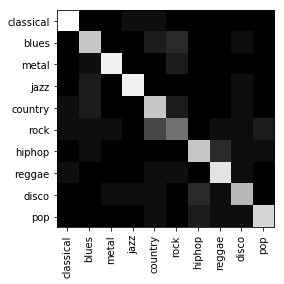

In [30]:
predict = GTZAN_CV1.predict(GTZAN_X_test)
print(accuracy_score(GTZAN_y_test, predict))
print(f1_score(GTZAN_y_test, predict, average = 'macro'))
display_cm(GTZAN_y_test, predict, pd.unique(GTZAN_y_test))

0.89


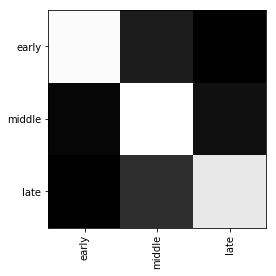

In [32]:
indicators = [['classical'], ['country', 'blues', 'rock', 'jazz', 'reggae', 'metal'], ['disco', 'hiphop', 'pop']]
labels = ['early', 'middle', 'late']
parent_predict = []
for p in predict:
    for j, i in enumerate(indicators):
        if p in i:
            parent_predict.append(labels[j])
parent_predict = np.array(parent_predict)
parent_y, _, _ = hierarchical_taxonomy(GTZAN_X_test, GTZAN_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
display_cm(parent_y, parent_predict, pd.unique(parent_y))

0.895
0.895


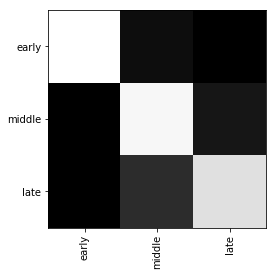

0.675
0.675


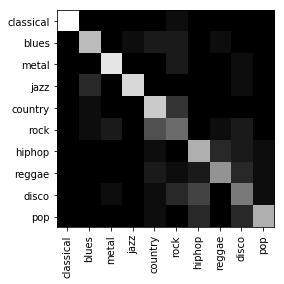

In [34]:
parent_predict = GTZAN_hier.parent_predict(GTZAN_X_test)
parent_y, _, _ = hierarchical_taxonomy(GTZAN_X_test, GTZAN_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
print(f1_score(parent_y, parent_predict, average = 'micro'))
display_cm(parent_y, parent_predict, labels)
predict = GTZAN_hier.predict(GTZAN_X_test, parent_predict = parent_predict)
print(accuracy_score(GTZAN_y_test, predict))
print(f1_score(GTZAN_y_test, predict, average = 'micro'))
display_cm(GTZAN_y_test, predict, pd.unique(GTZAN_y_test))

0.62 25
0.6208582276297295


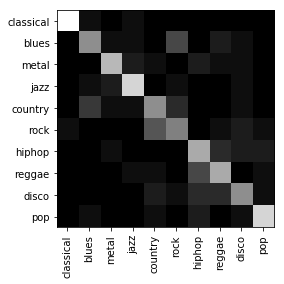

0.61 50
0.6073574007923616


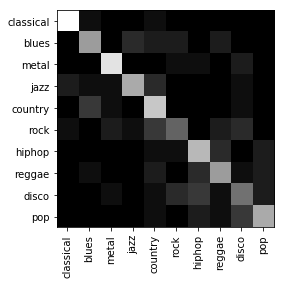

0.66 75
0.651026591933831


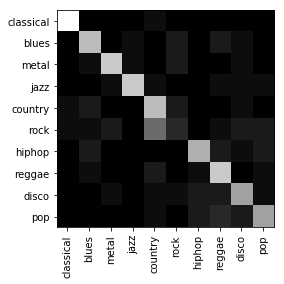

0.61 100
0.6008956292621247


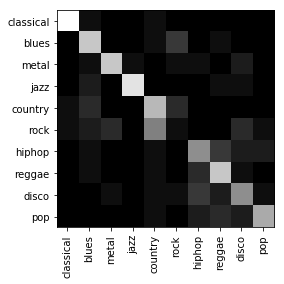

0.7 125
0.6958173570237591


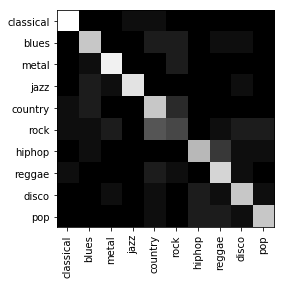

0.885


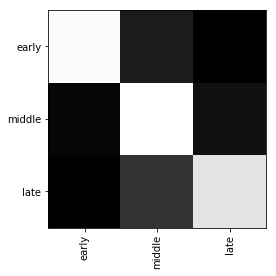

In [65]:
predicts = GTZAN_multi.predict(apply_selection(GTZAN_test, GTZAN_selection))
for i, p in enumerate(predicts):
    print(str(accuracy_score(GTZAN_y_test, p)) + " " + str(len(GTZAN_selection[i])))
    print(f1_score(GTZAN_y_test, p, average = 'weighted'))
    display_cm(GTZAN_y_test, p, pd.unique(GTZAN_y_test))
    
indicators = [['classical'], ['country', 'blues', 'rock', 'jazz', 'reggae', 'metal'], ['disco', 'hiphop', 'pop']]
labels = ['early', 'middle', 'late']
parent_predict = []
for p in predicts[4]:
    for j, i in enumerate(indicators):
        if np.array(p) in i:
            parent_predict.append(labels[j])
parent_predict = np.array(parent_predict)
parent_y, _, _ = hierarchical_taxonomy(GTZAN_X_test, GTZAN_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
display_cm(parent_y, parent_predict, pd.unique(parent_y))

0.585 25
0.5837862697199144


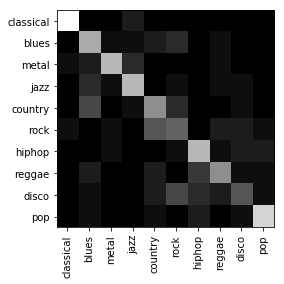

0.645 50
0.6435781612097402


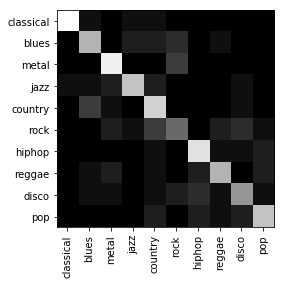

0.63 75
0.6258340294720299


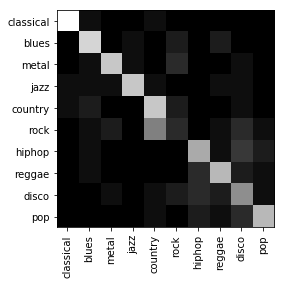

0.625 100
0.6217013224835503


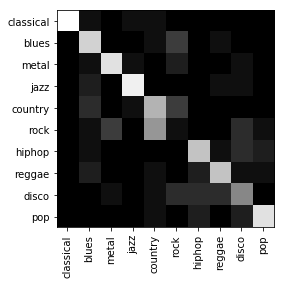

0.655 125
0.6537411260283712


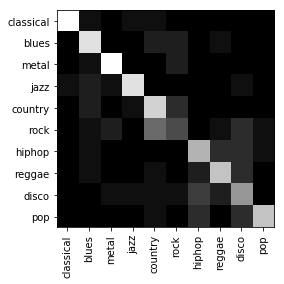

0.875


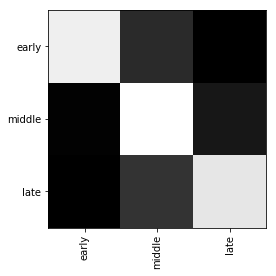

In [55]:
predicts = GTZAN_multi2.predict(apply_selection(GTZAN_test, GTZAN_selection))
for i, p in enumerate(predicts):
    print(str(accuracy_score(GTZAN_y_test, p)) + " " + str(len(GTZAN_selection[i])))
    print(f1_score(GTZAN_y_test, p, average = 'weighted'))
    display_cm(GTZAN_y_test, p, pd.unique(GTZAN_y_test))
parent_predict = []
for p in predicts[4]:
    for j, i in enumerate(indicators):
        if np.array(p) in i:
            parent_predict.append(labels[j])
parent_predict = np.array(parent_predict)
parent_y, _, _ = hierarchical_taxonomy(GTZAN_X_test, GTZAN_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
display_cm(parent_y, parent_predict, pd.unique(parent_y))

In [54]:
np.array(predicts[4][1]) in indicators[0]

False

0.7225404732254047
0.5652970484082454


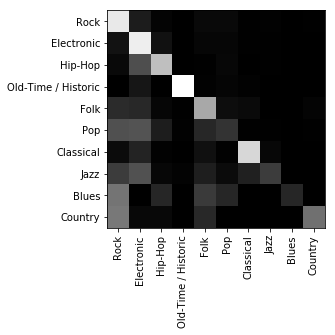

0.8458281444582815


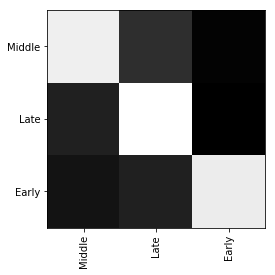

In [62]:
predict = FMA_CV1.predict(FMA_X_test)
print(accuracy_score(FMA_y_test, predict))
print(f1_score(FMA_y_test, predict, average = 'macro'))
display_cm(FMA_y_test, predict, pd.unique(FMA_y_test))

indicators = [["Classical", "Old-Time / Historic"], ["Country", "Rock", "Blues", "Jazz", "Folk"], ["Electronic", "Hip-Hop", "Pop"]]
labels = ["Early", "Middle", "Late"]
parent_predict = []
for p in predict:
    for j, i in enumerate(indicators):
        if p in i:
            parent_predict.append(labels[j])
parent_predict = np.array(parent_predict)
parent_y, _, _ = hierarchical_taxonomy(FMA_X_test, FMA_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
display_cm(parent_y, parent_predict, pd.unique(parent_y))

0.8483188044831881
0.8290698484002498


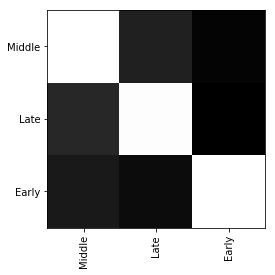

0.7207970112079701
0.5484066647237751


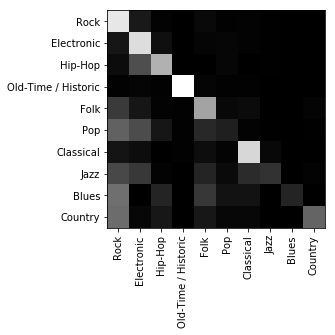

In [27]:
indicators = [["Classical", "Old-Time / Historic"], ["Country", "Rock", "Blues", "Jazz", "Folk"], ["Electronic", "Hip-Hop", "Pop"]]
labels = ["Early", "Middle", "Late"]
parent_predict = FMA_hier.parent_predict(FMA_X_test)
parent_y, _, _ = hierarchical_taxonomy(FMA_X_test, FMA_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
print(f1_score(parent_y, parent_predict, average = 'macro'))
display_cm(parent_y, parent_predict, pd.unique(parent_y))
predict = FMA_hier.predict(FMA_X_test, parent_predict = parent_predict)
print(accuracy_score(FMA_y_test, predict))
print(f1_score(FMA_y_test, predict, average = 'macro'))
display_cm(FMA_y_test, predict, pd.unique(FMA_y_test))

0.6273972602739726 25
0.4406886860777794


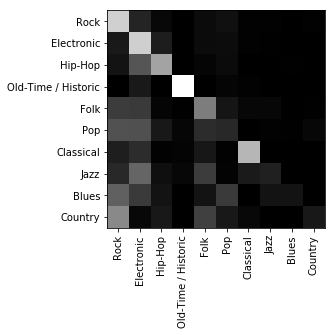

0.6341220423412204 50
0.4727123692506547


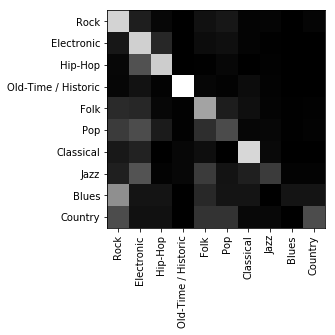

0.6677459526774595 75
0.5188042752383168


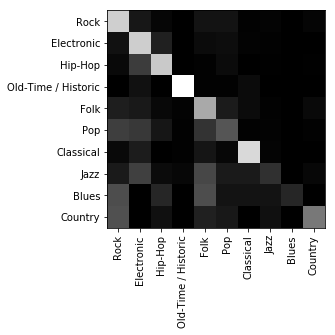

0.6978829389788294 100
0.5554402620480869


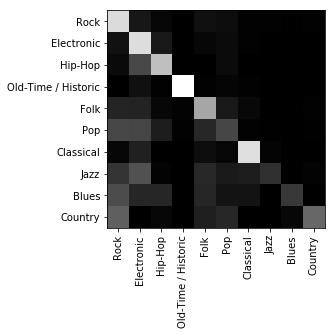

0.7145703611457036 125
0.5617155198399153


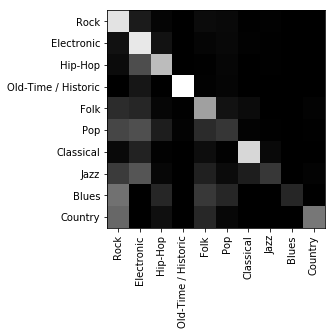

0.8433374844333749


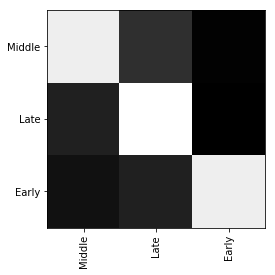

In [64]:
predicts = FMA_multi.predict(apply_selection(FMA_test, FMA_selection))
for i, p in enumerate(predicts):
    print(str(accuracy_score(FMA_y_test, p)) + " " + str(len(FMA_selection[i])))
    print(f1_score(FMA_y_test, p, average = 'macro'))
    display_cm(FMA_y_test, p, pd.unique(FMA_y_test))
indicators = [["Classical", "Old-Time / Historic"], ["Country", "Rock", "Blues", "Jazz", "Folk"], ["Electronic", "Hip-Hop", "Pop"]]
labels = ["Early", "Middle", "Late"]
parent_predict = []
for p in predicts[4]:
    for j, i in enumerate(indicators):
        if p in i:
            parent_predict.append(labels[j])
parent_predict = np.array(parent_predict)
parent_y, _, _ = hierarchical_taxonomy(FMA_X_test, FMA_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
display_cm(parent_y, parent_predict, pd.unique(parent_y))

0.6122042341220424 25
0.4478381481216749


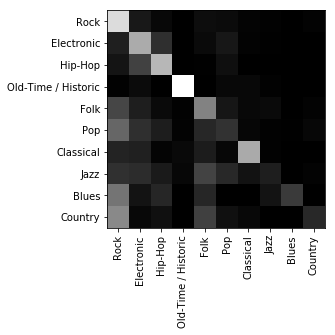

0.638854296388543 50
0.46527788812774096


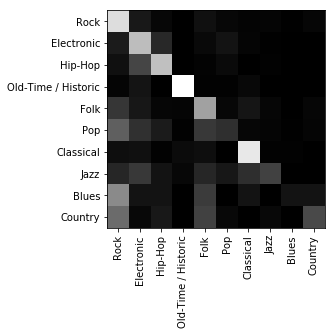

0.6702366127023661 75
0.5047894962565989


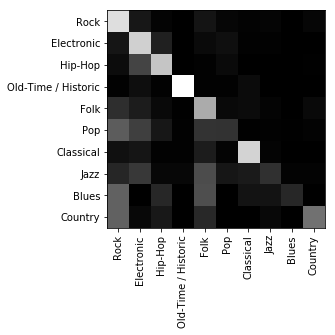

0.6978829389788294 100
0.547153596655065


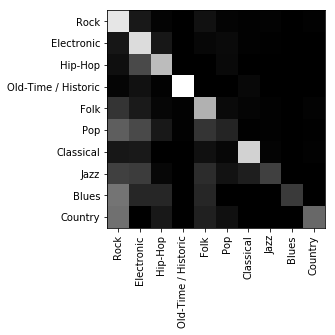

0.7073474470734745 125
0.5522679553977333


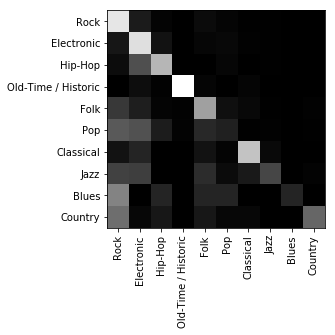

0.8428393524283935


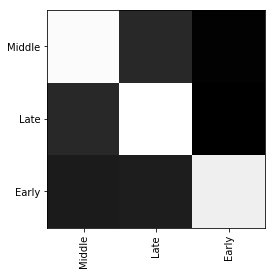

In [66]:
predicts = FMA_multi2.predict(apply_selection(FMA_test, FMA_selection))
for i, p in enumerate(predicts):
    print(str(accuracy_score(FMA_y_test, p)) + " " + str(len(FMA_selection[i])))
    print(f1_score(FMA_y_test, p, average = 'macro'))
    display_cm(FMA_y_test, p, pd.unique(FMA_y_test))
indicators = [["Classical", "Old-Time / Historic"], ["Country", "Rock", "Blues", "Jazz", "Folk"], ["Electronic", "Hip-Hop", "Pop"]]
labels = ["Early", "Middle", "Late"]
parent_predict = []
for p in predicts[4]:
    for j, i in enumerate(indicators):
        if p in i:
            parent_predict.append(labels[j])
parent_predict = np.array(parent_predict)
parent_y, _, _ = hierarchical_taxonomy(FMA_X_test, FMA_y_test, indicators, labels = labels)
print(accuracy_score(parent_y, parent_predict))
display_cm(parent_y, parent_predict, pd.unique(parent_y))